In [2]:
# Zachary Katz
# zachary_katz@mines.edu
# 04 August 2025

"""

Download ATL 11 granule if necessary
Extract example with multiple crossing tracks
"""

# Imports
import earthaccess
from pathlib import Path
import h5py
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from shapely.geometry import Point, Polygon, shape
import shapefile
import cartopy.crs as ccrs
from pyproj import CRS, Transformer
import re
import scipy
from itertools import combinations
import matplotlib.ticker as ticker

# User-defined path
data_path = './_data/ATL11'
gl_path = '/Users/zachary_katz/Research/Antarctica_Masks/scripps_antarctica_polygons_v1.shp'
auth = earthaccess.login(strategy='netrc')

In [ ]:
# Earthaccess unable to handle crossing 180 deg so download in two chunks
short_name = 'ATL11'
bbox_west = (-180,-86, -140,-75)
bbox_east = (155,-86,180, -75)

st = '2021-01-01'
ed = '2025-06-01'
# Download ATL11 if necessary
results = earthaccess.search_data(short_name = 'ATL11', 
bounding_box = bbox_east)
temporal = (st,ed)
print(len(results))
earthaccess.download(results, data_path, provider='POCLOUD')

results = earthaccess.search_data(short_name = 'ATL11', 
bounding_box = bbox_west)
temporal = (st,ed)
print(len(results))
earthaccess.download(results, data_path, provider='POCLOUD')

569


QUEUEING TASKS | :   0%|          | 0/569 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/569 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/569 [00:00<?, ?it/s]

800


QUEUEING TASKS | :   0%|          | 0/800 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/800 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/800 [00:00<?, ?it/s]

['_data/ATL11/ATL11_000711_0326_006_12.h5',
 '_data/ATL11/ATL11_000712_0326_006_12.h5',
 '_data/ATL11/ATL11_000811_0326_006_12.h5',
 '_data/ATL11/ATL11_000812_0326_006_12.h5',
 '_data/ATL11/ATL11_000911_0326_006_12.h5',
 '_data/ATL11/ATL11_001311_0326_006_12.h5',
 '_data/ATL11/ATL11_001410_0326_006_12.h5',
 '_data/ATL11/ATL11_001411_0326_006_12.h5',
 '_data/ATL11/ATL11_001510_0326_006_12.h5',
 '_data/ATL11/ATL11_001511_0326_006_12.h5',
 '_data/ATL11/ATL11_002211_0326_006_12.h5',
 '_data/ATL11/ATL11_002212_0326_006_12.h5',
 '_data/ATL11/ATL11_002311_0326_006_12.h5',
 '_data/ATL11/ATL11_002312_0326_006_12.h5',
 '_data/ATL11/ATL11_002411_0326_006_12.h5',
 '_data/ATL11/ATL11_002811_0326_006_12.h5',
 '_data/ATL11/ATL11_002910_0326_006_12.h5',
 '_data/ATL11/ATL11_002911_0326_006_12.h5',
 '_data/ATL11/ATL11_003010_0326_006_12.h5',
 '_data/ATL11/ATL11_003011_0326_006_12.h5',
 '_data/ATL11/ATL11_003712_0326_006_12.h5',
 '_data/ATL11/ATL11_003811_0326_006_12.h5',
 '_data/ATL11/ATL11_003812_0326_

In [3]:
files = list(Path(data_path).glob('*.h5'))
files = list(Path(data_path).glob('*102111*.h5'))
files += list(Path(data_path).glob('*107511*.h5'))
files += list(Path(data_path).glob('*112111*.h5'))
files += list(Path(data_path).glob('*134011*.h5'))

len(files)


4

In [4]:
def plot_shapefile(
    records: list[shapefile._Record],
    shapes: list[shapefile.Shape],
    ax ,
    colors: list[str],
    transform,
    fill: bool = False,
) -> None:
    """
    Plots the given records and shapes on axis ax.

    Parameters
    ----------
    records : list[shapefile._Record]
        Shapely record containing shape classification
    shapes : list[shapefile.Shape]
        Shapely shape points
    ax : cartopy.mpl.geoaxes.GeoAxes
        Axes to polot on
    colors : list[str]
       [Grounded ice color, Ice Shelf color]; Must be length 2
    """
    for record, shape in zip(records, shapes):
        classification = record[field_names.index("Id_text")]
        points = shape.points
        parts = list(shape.parts)
        parts.append(
            len(points)
        )  # Append the end index of the last part of the shapefile
        for i in range(len(parts) - 1):
            part = points[parts[i] : parts[i + 1]]
            if (
                classification == "Isolated island"
                or classification == "Ice rise or connected island"
                or classification == "Grounded ice or land"
            ):
                if fill:
                    ax.fill(*zip(*part), color=colors[0], zorder=2,transform=transform)
                else:
                    ax.plot(*zip(*part), color=colors[0], linewidth=1.5, zorder=2,transform=transform)
            elif classification == "Ice shelf":
                if fill:
                    ax.fill(*zip(*part), color=colors[1], zorder=2,transform=transform)
                else:
                    ax.plot(*zip(*part), color=colors[1], linewidth=1.5, zorder=2,transform=transform)
            else:
                print(f"Unknown classification: {classification}")

In [ ]:
# Load ross polygon
ice_shelf_polygons = []
grounded_polygons = []

sf = shapefile.Reader(gl_path)
fields = sf.fields[1:] # Skip deletion flag
field_names = [field[0] for field in fields]
records = sf.records()
shapes = sf.shapes()

for record, shape in zip(records, shapes):
    classification = record[field_names.index("Id_text")]
    points = shape.points
    parts = list(shape.parts)
    parts.append(len(points))  # Append the end index of the last part
    for i in range(len(parts) - 1):
        part = points[parts[i]:parts[i + 1]]
        polygon = shapely.Polygon(part)
        if classification == "Isolated island" or classification == "Ice rise or connected island" or classification == "Grounded ice or land":
            if polygon.is_valid:
                grounded_polygons.append(polygon)
        elif classification == "Ice shelf":
            if polygon.is_valid:
                ice_shelf_polygons.append(polygon)
        else:
            print(f"Unknown classification: {classification}")


bbox = [-200000,-1800000,0,-800000] #Ross
bbox = [1950000,590000,1951000,791000] #Amery
# Filter records and shapes to bbox
filtered_records = []
filtered_shapes = []
for record, shape in zip(records, shapes):
    shape_bbox = shape.bbox
    # Checks if any part of the shape is within the bounding box
    classification = record[field_names.index("Id_text")]
    if (
        shape_bbox[0] < bbox[2]
        and shape_bbox[2] > bbox[0]
        and shape_bbox[1] < bbox[3]
        and shape_bbox[3] > bbox[1]
    ) and  classification == "Ice shelf":
        filtered_records.append(record)
        filtered_shapes.append(shape)

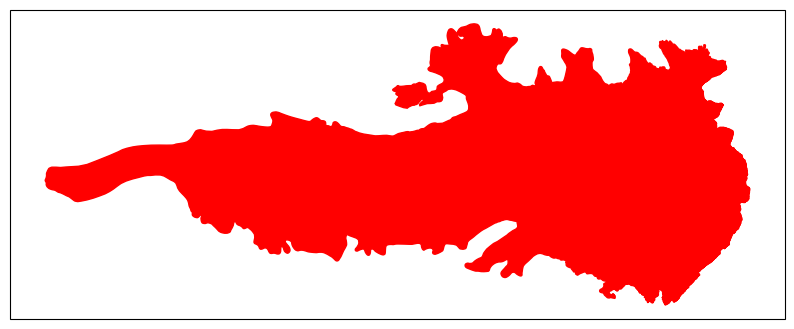

In [8]:
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ps71_projection},
)
plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "red"], ps71_projection, fill=True)

In [7]:
def ll2xy(lon: list[float], lat: list[float]) -> tuple[list[float], list[float]]:
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y).
    Can also take single floats.

    Parameters
    ----------
    lon: list[float]
         Geodetic longitude in EPSG:4326
    lat: list[float]
         Geodetic latitude in EPSG:4326

    Returns
    -------
    x: list[float]
       Antarctic Polar Stereographic (EPSG:3031) x
    y: list[float]
       Antarctic Polar Stereographic (EPSG:3031) y
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

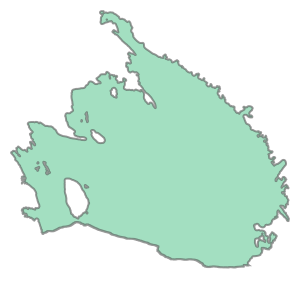

In [8]:
from shapely.geometry import Point, Polygon, shape
ross = shape(filtered_shapes[0].__geo_interface__)
ross

In [9]:
# Tidal constituents [hr]
HR_IN_DAY = 24
SEC_IN_HR = 3600

M2 = 12.4206012
S2 = 12
N2 = 12.65834751
K2 = 11.96723606

K1 = 23.9344721
O1 = 25.81933871
P1 = 24.06588766
Q1 = 26.868350

constituents = {
    "M2": M2,
    "S2": S2,
    "N2": N2,
    "K2": K2,
    "K1": K1,
    "O1": O1,
    "P1": P1,
    "Q1": Q1,
}

In [10]:
### STREAMLINE EVERYTHING BELOW IN 20 FILE CHUNKS ###

# Each reference track pair is a group
group = ['/pt1/','/pt2/','/pt3/']

chunk_size = 20
num_chunks = (len(files) + chunk_size - 1) // chunk_size 

### TEST ON ONE CHUNK ###
num_chunks = 1

for chunk_idx in range(num_chunks):
    start_idx = chunk_idx * chunk_size
    end_idx = min(start_idx + chunk_size, len(files))
    file_chunk = files[start_idx:end_idx]

    print(f"Processing chunk {chunk_idx+1}/{num_chunks} with {len(file_chunk)} files...")

    # Make array of ATL11 data
    print("ATL11 Data Array")
    data_arr = []
    # Loop over files
    for file in file_chunk:
        # Loop over pairs
        for i, g in enumerate(group):
            data = {}
            # Load variables into dictionary list
            with h5py.File(file, 'r') as fi:

                data['t_ref'] = fi['/ancillary_data/atlas_sdp_gps_epoch'][:] # ICESat-2 reference epoch
                data['filename'] = file
                data['group'] = g
            
                # Crossing track data
                data['x_q_flag'] = fi[g+'crossing_track_data/atl06_quality_summary'][:] #0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
                data['x_lat'] = fi[g+'crossing_track_data/latitude'][:] # Latitude [degrees]
                data['x_lon'] = fi[g+'crossing_track_data/longitude'][:] # Longitude [degrees]
                data['x_h_corr'] = fi[g+'crossing_track_data/h_corr'][:] # Mean corrected height [m]
                data['x_t_dt'] = fi[g+'crossing_track_data/delta_time'][:] # GPS seconds since reference epoch
                data['x_cycle_number'] = fi[g+'crossing_track_data/cycle_number'][:] # Cycle
                data['x_rgt'] = fi[g+'crossing_track_data/rgt'][:] # Reference ground track
                data['x_spot_crossing'] = fi[g+'crossing_track_data/spot_crossing'][:] # Spot  number
                data['x_ref_pt'] = fi[g+'crossing_track_data/ref_pt'][:] # Reference point
                data['x_x'], data['x_y'] = ll2xy(data['x_lon'],data['x_lat'])
                data["x_dac"] = fi[g + "crossing_track_data/dac"][:]

                time_temp = data['t_ref'] + data['x_t_dt']
                data['x_time'] = Time(time_temp, format='gps').iso # Convert to readable time
                
                # Main track data
                data['lat'] = fi[g+'/latitude'][:] # Latitude [degrees]
                data['lon'] = fi[g+'/longitude'][:] # Longitude [degrees]
                data['h_corr'] = fi[g+'/h_corr'][:] # Mean corrected height [m]
                data['t_dt'] = fi[g+'/delta_time'][:] # GPS seconds since reference epoch
                data['q_flag'] = fi[g+'/quality_summary'][:] #0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
                data['cycle_number'] = fi[g+'/cycle_number'][:] # Cycle
                data['ref_pt'] = fi[g+'/ref_pt'][:] # Reference point
                time_temp = data['t_ref'] + data['t_dt']
                data['time'] = Time(time_temp, format='gps').iso # Convert to readable time
                data["dac"] = fi[g + "/cycle_stats/dac"][:]


                data['x'], data['y'] = ll2xy(data['lon'],data['lat'])
                
            data_arr.append(data)

    print("Downscaling to Ross Ice Shelf")
    # Downscale data so only in ross polygon
    for data in data_arr[:]:
        inside_mask = []
        x_inside_mask = []
        for xi, yi in zip(data['x'], data['y']):
            point = Point(xi, yi)
            inside_mask.append(ross.contains(point))
        data['inside_mask'] = inside_mask

        for xi, yi in zip(data['x_x'], data['x_y']):
            point = Point(xi, yi)
            x_inside_mask.append(ross.contains(point))

        data['x_inside_mask'] = x_inside_mask

    print("Creating Crossover Table")
    # Loop over each track and create crossover table
    dfs = []
    for data in data_arr[:]:
        i = 0
        for ref_pt in data['ref_pt'][data['inside_mask']]:

            mskx = (data['x_ref_pt'] == ref_pt) & (data['x_t_dt'] < 2e300)
            msk = (data['ref_pt'] == ref_pt)
            mskd_lat = data['lat'][msk]
            mskd_lon = data['lon'][msk]
            mskd_xlat = data['x_lat'][mskx]
            mskd_xlon = data['x_lon'][mskx]
            mskd_xt = data['x_time'][mskx]
            mskd_xcycle = data['x_cycle_number'][mskx]
            mskd_xrgt = data['x_rgt'][mskx]
            mskd_xdac = data["x_dac"][mskx]

            mskd_t = data['time'][msk]
            mskd_dac = data["dac"][msk]

            mskd_tdt = data['t_dt'][msk]
            msk_t = mskd_tdt < 2e300
            mskd_t = mskd_t[msk_t]
            mskd_dac = mskd_dac[msk_t]

            mskd_h = data['h_corr'][msk]
            mskd_h = mskd_h[msk_t]
            mskd_xh = data['x_h_corr'][mskx]
            
            mskd_q = data['q_flag'][msk]
            mskd_q = mskd_q[msk_t]
            mskd_xq = data['x_q_flag'][mskx]

            msk_t = msk_t.flatten()
            mskd_cycle = data['cycle_number'][msk_t]

            mskd_lon = np.ones(len(mskd_t)) * mskd_lon
            mskd_lat = np.ones(len(mskd_t)) * mskd_lat

            match = re.search(r'ATL11_(\d{4})', str(data['filename']))
            mskd_rgt = np.ones(len(mskd_t),dtype=int) * int(match.group(1))
            
            if len(mskd_xlat) > 5:
                df1 = pd.DataFrame(
                {
                    'lat': mskd_xlat,
                    'lon': mskd_xlon,
                    'time': mskd_xt,
                    'height': mskd_xh,
                    'q_flag': mskd_xq,
                    'cycle_number': mskd_xcycle,
                    'rgt': mskd_xrgt,
                    "dac": mskd_xdac,
                }
                )
                df2 = pd.DataFrame(
                    {
                        'lat': mskd_lat,
                        'lon': mskd_lon,
                        'time': mskd_t,
                        'height': mskd_h,
                        'q_flag': mskd_q,
                        'cycle_number': mskd_cycle,
                        'rgt': mskd_rgt,
                        "dac": mskd_dac,
                        
                    }
                )
                df = pd.concat([df1,df2], ignore_index=True)
                df = df.sort_values(by=['time']).reset_index(drop=True)

                df["datetime"] = df["time"]
                df["time"] = (
                    pd.to_datetime(df["time"]) - pd.to_datetime(df["time"].iloc[0])
                ).dt.total_seconds() / SEC_IN_HR
                dfs.append(df)

Processing chunk 1/1 with 4 files...
ATL11 Data Array


/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/miniconda3/envs/gps/lib/python3.12/site-packages/erfa/core.py:16223: RuntimeWarning: invalid value en

Downscaling to Ross Ice Shelf
Creating Crossover Table


/var/folders/q8/gfrrq79j2dzfr1jycf0w8bhh0000gx/T/ipykernel_850/2778438568.py:157: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["time"]) - pd.to_datetime(df["time"].iloc[0])
/var/folders/q8/gfrrq79j2dzfr1jycf0w8bhh0000gx/T/ipykernel_850/2778438568.py:157: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["time"]) - pd.to_datetime(df["time"].iloc[0])
/var/folders/q8/gfrrq79j2dzfr1jycf0w8bhh0000gx/T/ipykernel_850/2778438568.py:157: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["time"]) - pd.to_datetime(df["time"].iloc[0])
/var

In [11]:
# Try complex fit
# SKIP THIS CELL FOR NOW - DIAGNOSE WHY DIFFERENT
"""
periods = [constituents[c] for c in constituents]

tide_analyses = {'xs': [], 'ys':[],'amplitudes':[], 'phases': [], 'lats':[],'lons':[]}
for df in dfs[:]:
    y = df["height"].values - df["dac"].values
    t = df["time"].values
    X = np.vstack([np.exp(1j * 2 * np.pi * t / period) for period in periods]).T
    c_fit, *_ = np.linalg.lstsq(X, 1j * y, rcond=None)

    amp = np.abs(c_fit)
    phase = np.angle(c_fit) % (2 * np.pi) * 180 / np.pi 
    x, y = ll2xy(df['lon'][0],df['lat'][0])
    tide_analyses['xs'].append(x)
    tide_analyses['ys'].append(y)
    tide_analyses['lats'].append(df['lat'][0])
    tide_analyses['lons'].append(df['lon'][0])
    tide_analyses['amplitudes'].append(amp)
    tide_analyses['phases'].append(phase)

"""

'\nperiods = [constituents[c] for c in constituents]\n\ntide_analyses = {\'xs\': [], \'ys\':[],\'amplitudes\':[], \'phases\': [], \'lats\':[],\'lons\':[]}\nfor df in dfs[:]:\n    y = df["height"].values - df["dac"].values\n    t = df["time"].values\n    X = np.vstack([np.exp(1j * 2 * np.pi * t / period) for period in periods]).T\n    c_fit, *_ = np.linalg.lstsq(X, 1j * y, rcond=None)\n\n    amp = np.abs(c_fit)\n    phase = np.angle(c_fit) % (2 * np.pi) * 180 / np.pi \n    x, y = ll2xy(df[\'lon\'][0],df[\'lat\'][0])\n    tide_analyses[\'xs\'].append(x)\n    tide_analyses[\'ys\'].append(y)\n    tide_analyses[\'lats\'].append(df[\'lat\'][0])\n    tide_analyses[\'lons\'].append(df[\'lon\'][0])\n    tide_analyses[\'amplitudes\'].append(amp)\n    tide_analyses[\'phases\'].append(phase)\n\n'

In [12]:
# Try sinusoid fit
def tide_model(t, periods, parameters):
    """
    Generate the tide from synthetic data.

    Parameters
    ----------
    t : List
        List of sampling times in hours
    periods : dict
        Dictionary of tidal constituent periods in hours
    parameters : list
        List in form [A1, A2, ... , phi_1, phi_2, ...]
        where A is the amplitude in m and phi is the phase shift in radians

    Returns
    -------
    modeled : list
        Tides at time t as estimated by the model
    """
    assert len(parameters) == 2 * len(
        periods
    ), "Parameters must be twice the number of periods"

    model = np.zeros_like(t, dtype=float)
    n = len(periods)
    for i in range(n):
        A = parameters[i]
        phi = parameters[i + n]
        model += A * np.cos(2 * np.pi * t / periods[i] - phi)
    return model

def residuals(parameters, t, data, periods):
    """
    Residual function for scipy's least_squares
    Scipy does the squaring for us.
    """
    return tide_model(t, periods, parameters) - data

from scipy.optimize import least_squares
periods = [constituents[c] for c in constituents]

tide_analyses = {'xs': [], 'ys':[],'amplitudes':[], 'phases': [], 'lats':[],'lons':[]}
for df in dfs[:]:
    mskd_q = df['q_flag'] == 0
    mskd_h = df['height'].values[mskd_q]
    mskd_dac = df['dac'].values[mskd_q]
    y = scipy.signal.detrend(mskd_h - mskd_dac, type='linear')
    t = df["time"].values[mskd_q]
    initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    fit = least_squares(residuals, initial_guess, args=(t, y, periods))
    for n in range(8):
        if fit.x[n] < 0:
            fit.x[n + 8] += np.pi
    amp = np.abs(fit.x[:8])
    phase = fit.x[8:] % (2 * np.pi) * 180 / np.pi 
    x, y = ll2xy(df['lon'][0],df['lat'][0])
    tide_analyses['xs'].append(x)
    tide_analyses['ys'].append(y)
    tide_analyses['amplitudes'].append(amp)
    tide_analyses['phases'].append(phase)
    tide_analyses['lats'].append(df['lat'][0])
    tide_analyses['lons'].append(df['lon'][0])

In [13]:
# Calculate CATS tide at each location for comparison
import pyTMD
tide_dir = "~/Research/Background"
tide_mod = "CATS2008-v2023"
print("Setting up model")
model = pyTMD.io.model(tide_dir, format="netcdf").elevation(tide_mod)
constituents_pyTMD = pyTMD.io.OTIS.read_constants(
    model.grid_file,
    model.model_file,
    model.projection,
    type=model.type,
    grid=model.format,
)

lons = tide_analyses['lons'][:]
lats = tide_analyses['lats'][:]
c = constituents_pyTMD.fields

print("Extracting Tide Harmonics")
amp_pyTMD, ph_pyTMD, D = pyTMD.io.OTIS.interpolate_constants(
    np.atleast_1d(lons),
    np.atleast_1d(lats),
    constituents_pyTMD,
    type=model.type,
    method="spline",
    extrapolate=True,
)

# Downscale to just the 8 constitutents used in my simple Harmonic Analysis

amp_pyTMD = [ap[:8] for ap in amp_pyTMD]
ph_pyTMD = [p[:8] for p in ph_pyTMD]

tide_analyses['amp_pyTMD'] = amp_pyTMD
tide_analyses['ph_pyTMD'] = ph_pyTMD

Setting up model
Extracting Tide Harmonics


In [26]:
for i, const in enumerate(constituents): # Loop over amplitudes
    print(const)

M2
S2
N2
K2
K1
O1
P1
Q1


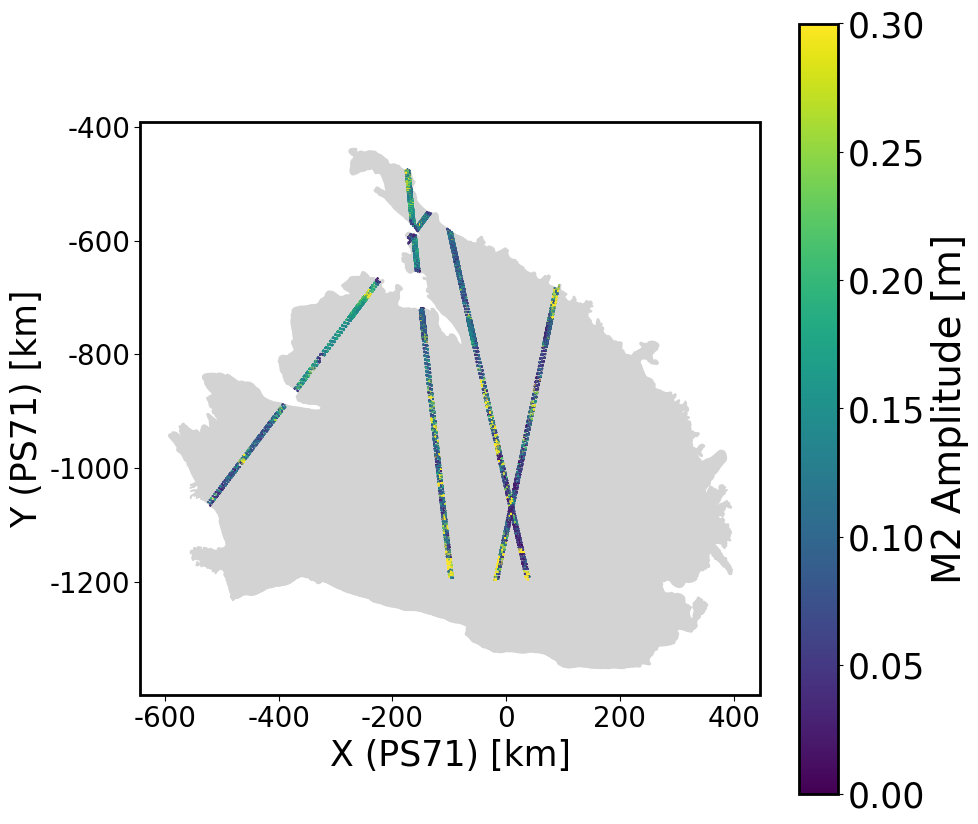

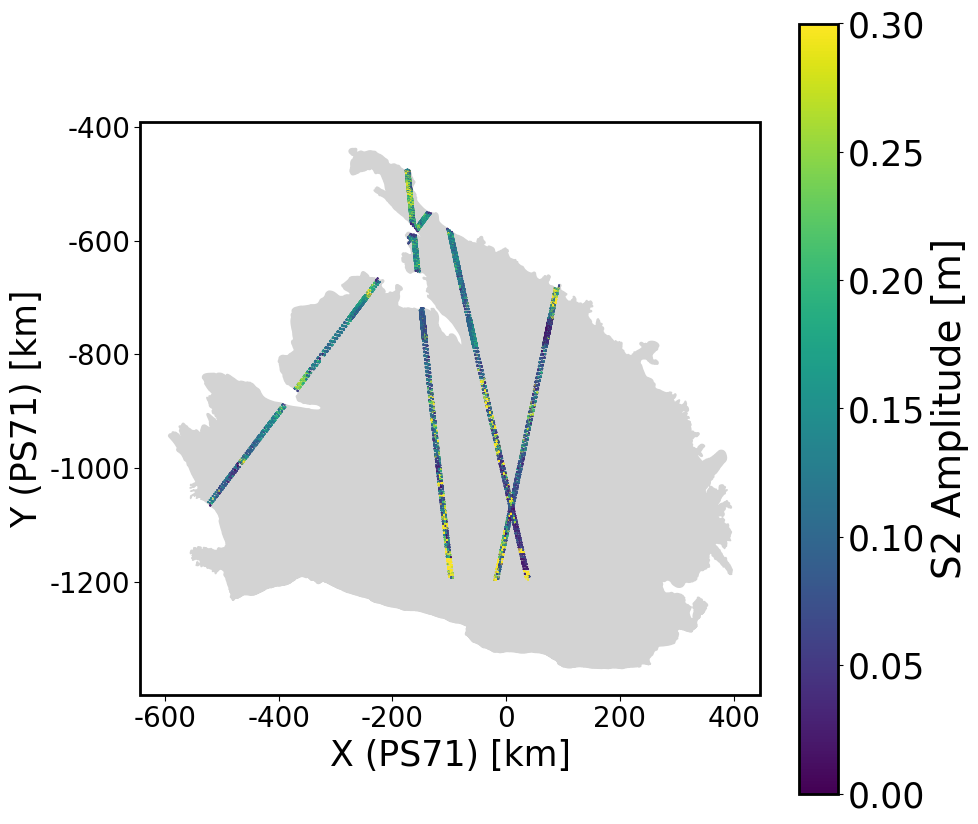

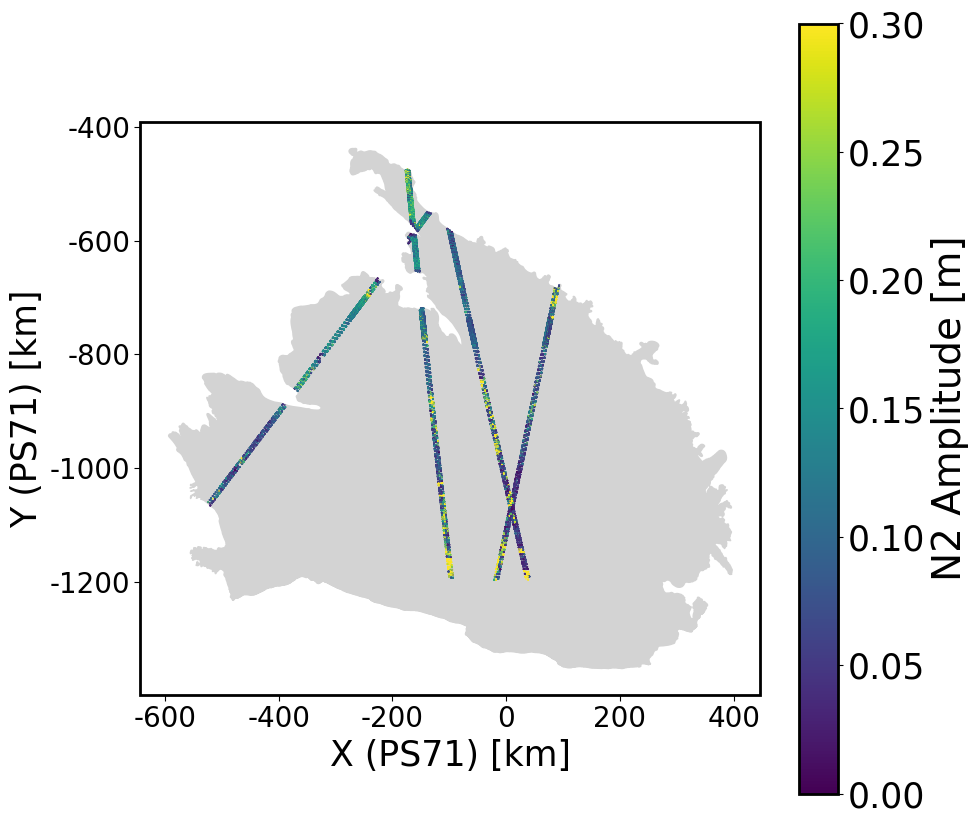

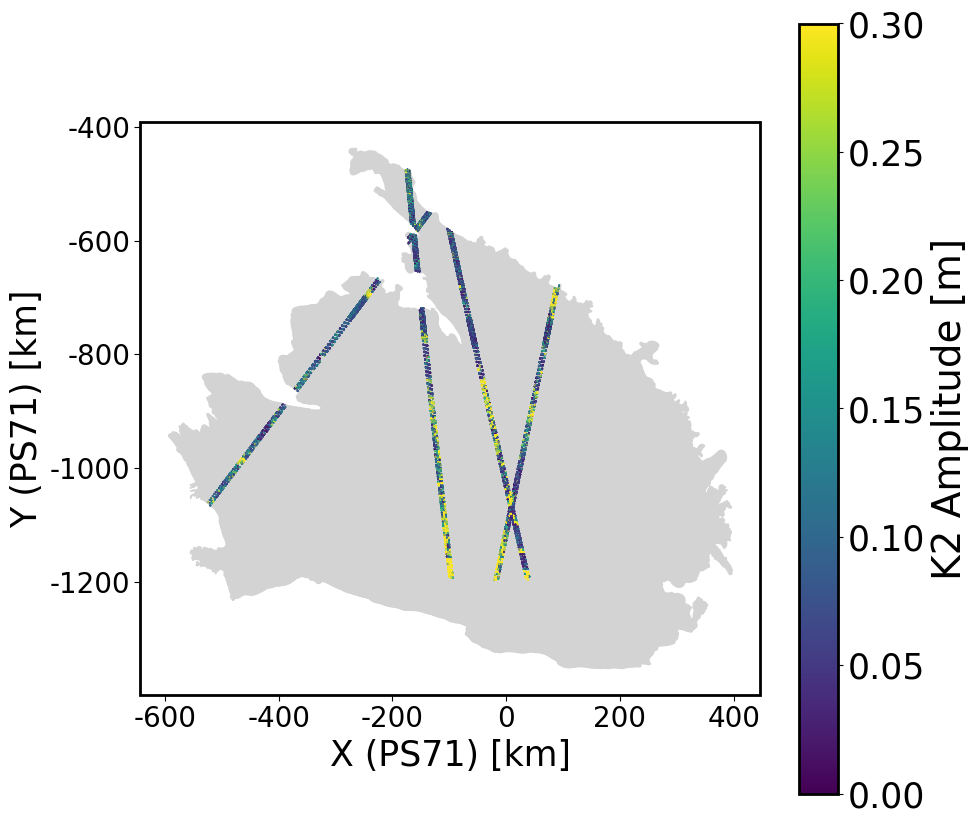

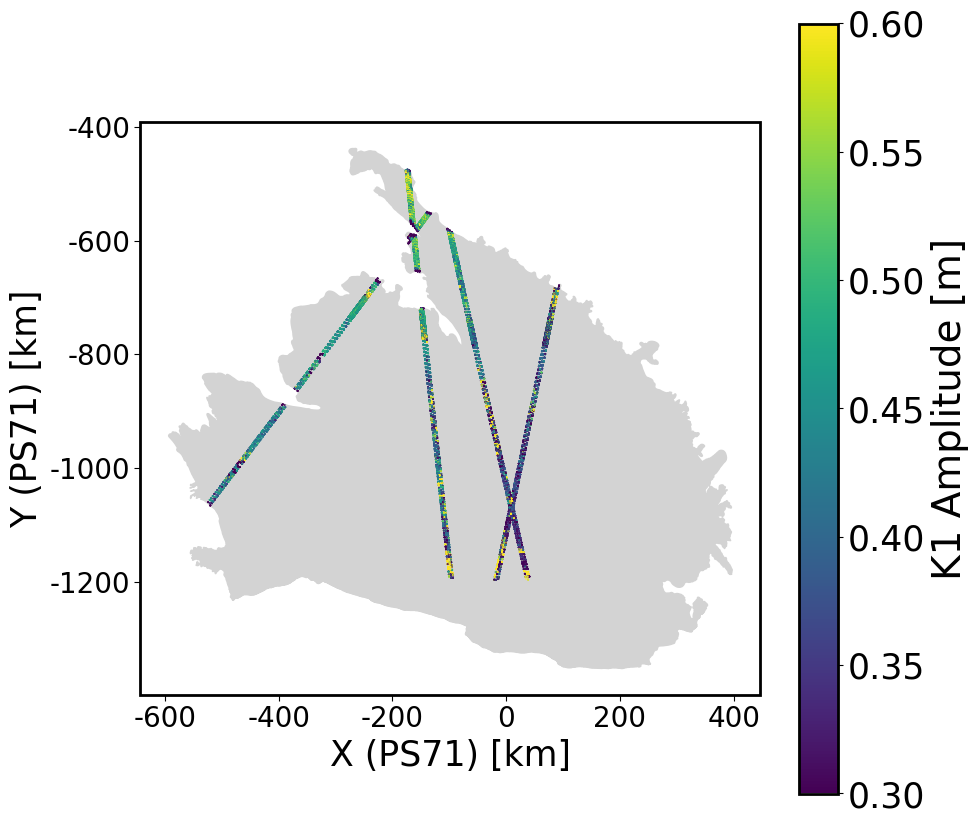

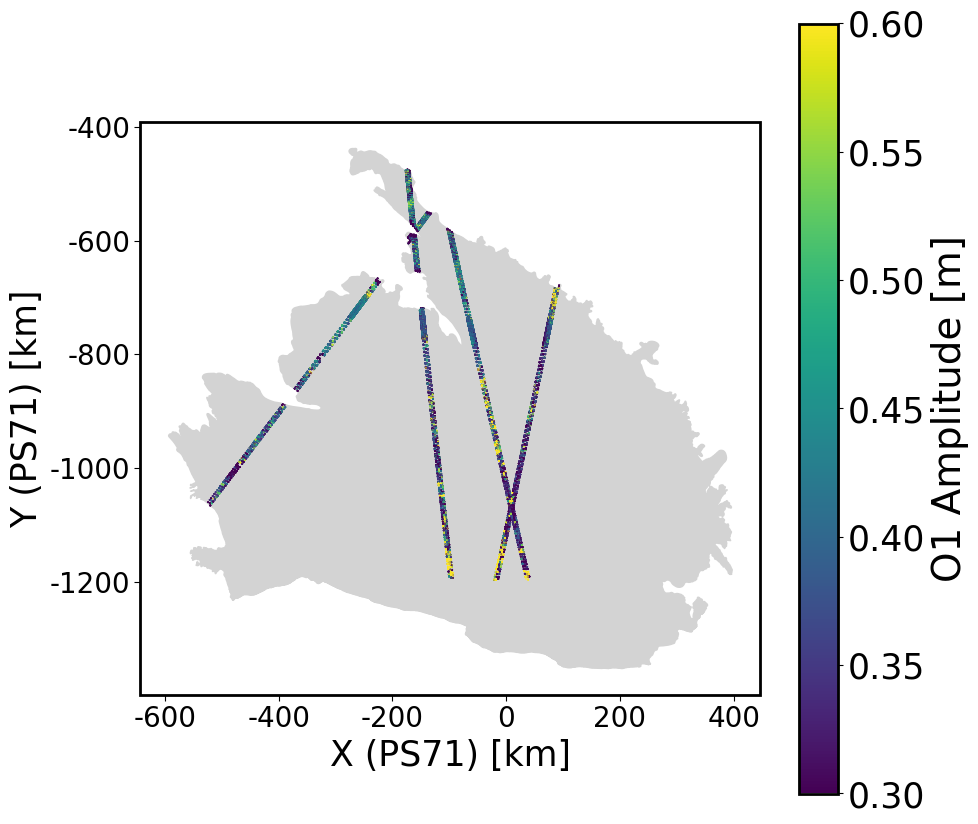

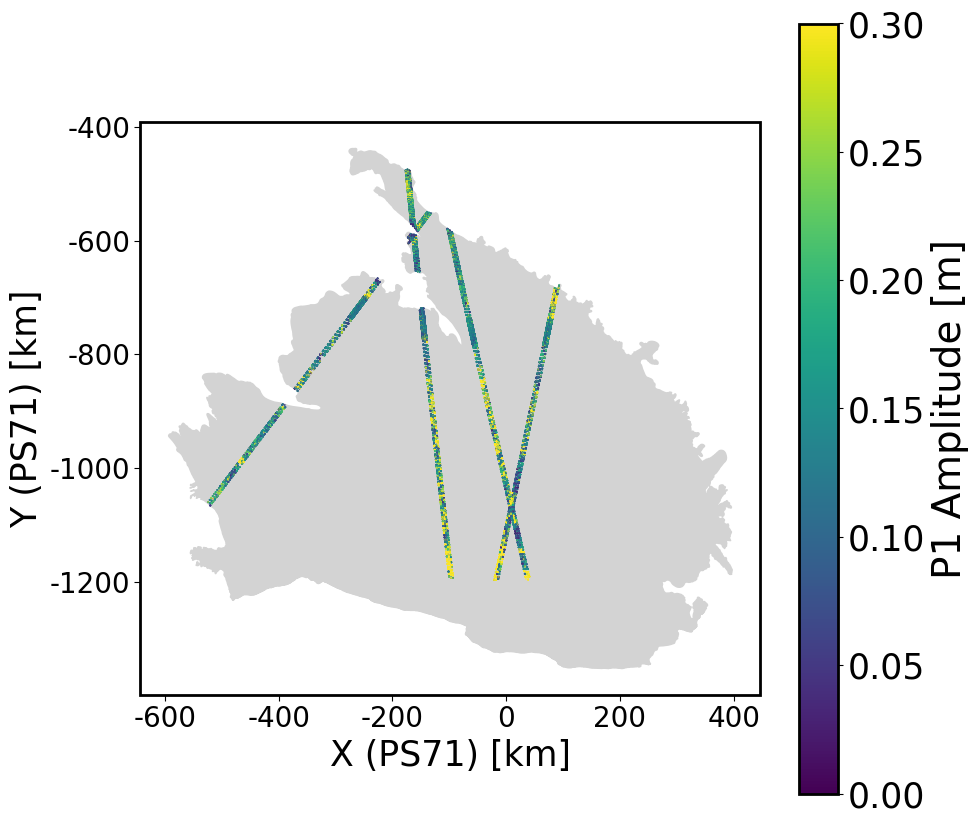

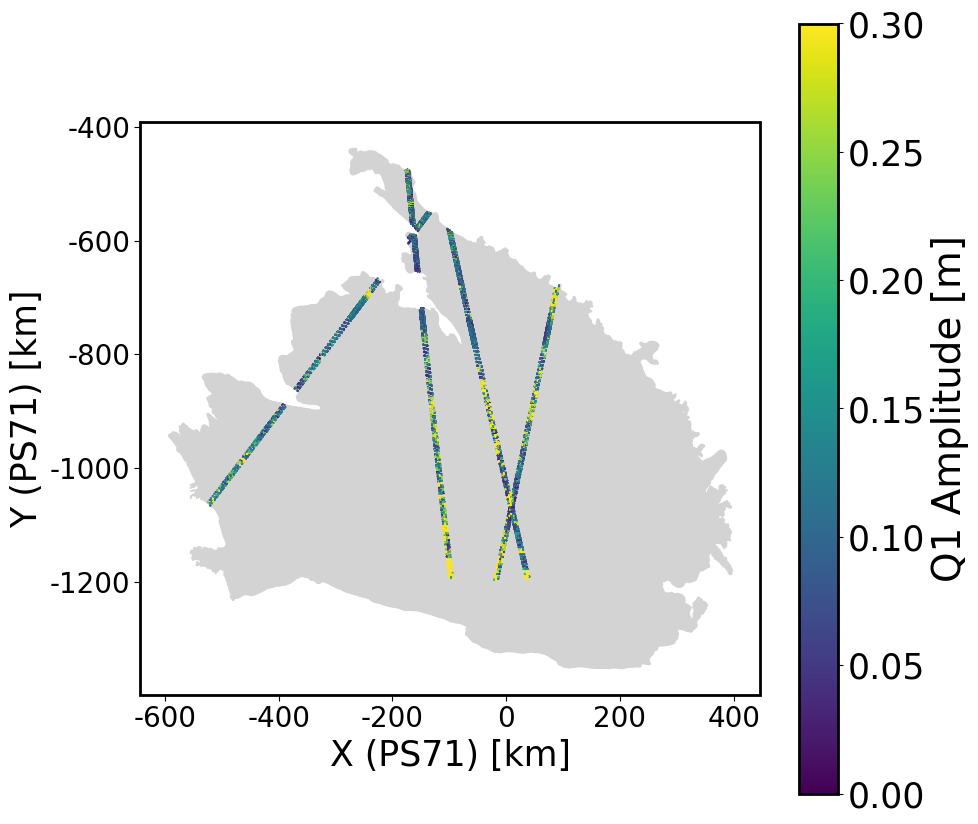

In [35]:
# Plot M2 as test
for i, const in enumerate(constituents): # Loop over amplitudes
    if const == 'K1' or const == 'O1':
        hmin = 0.3
        hmax = 0.6  
    else:
        hmin = 0
        hmax = 0.3
    ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
    fig, ax = plt.subplots(
        figsize=(10, 10),
        subplot_kw={'projection': ps71_projection},
    )
    plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "lightgray"], ps71_projection, fill=True)
    n = -1

    xs = np.array(tide_analyses['xs'][:n])
    ys = np.array(tide_analyses['ys'][:n])
    amps = np.array([a[i] for a in tide_analyses['amplitudes'][:n]])
    amps_pyTMD = np.array([a[i] for a in tide_analyses['amp_pyTMD'][:n]])
    amp_diff = amps - amps_pyTMD
    col = ax.scatter(xs, ys, s=0.1, zorder=10, c=amps, cmap='viridis',vmin=hmin,vmax=hmax)
    cbar = fig.colorbar(col)

    KM_SCALE = 1e3
    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_xlabel("X (PS71) [km]", size=25)
    ax.set_ylabel("Y (PS71) [km]", size=25)
    ax.tick_params(labelsize=20)
    ax.tick_params(size=4)

    cbar.ax.tick_params(labelsize=25)
    cbar.set_label(f"{const} Amplitude [m]", fontsize=28, color="black")
    fig.savefig(f"./output/{const}_ha_amp.png", bbox_inches="tight", dpi=300, transparent=True)

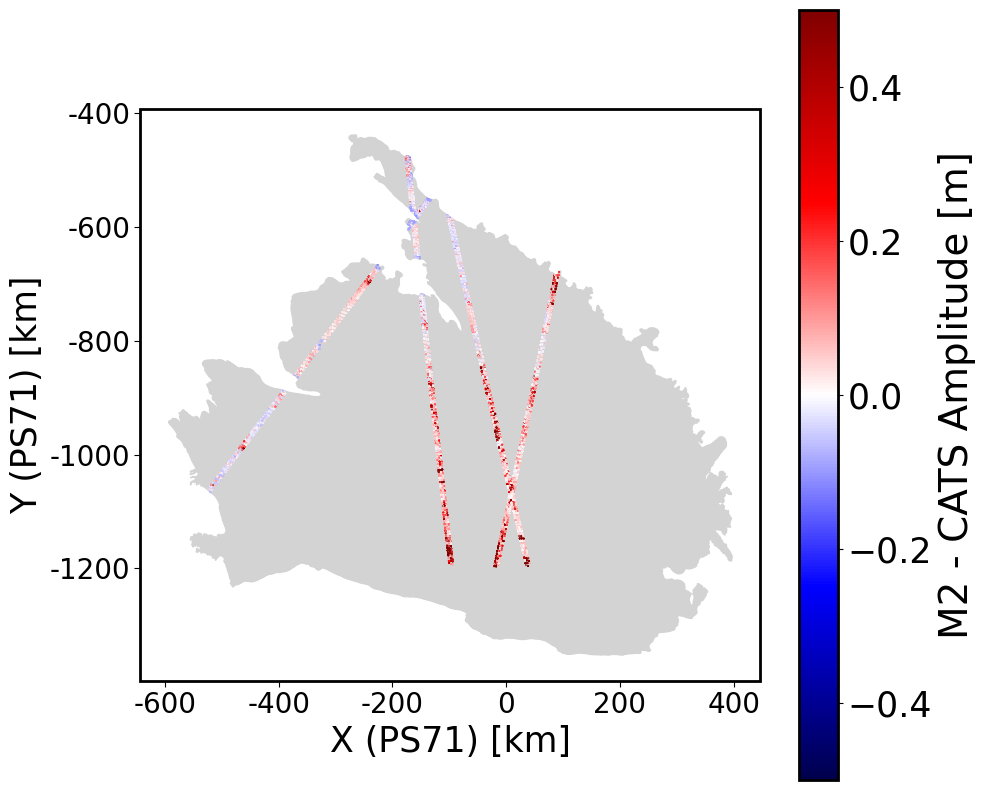

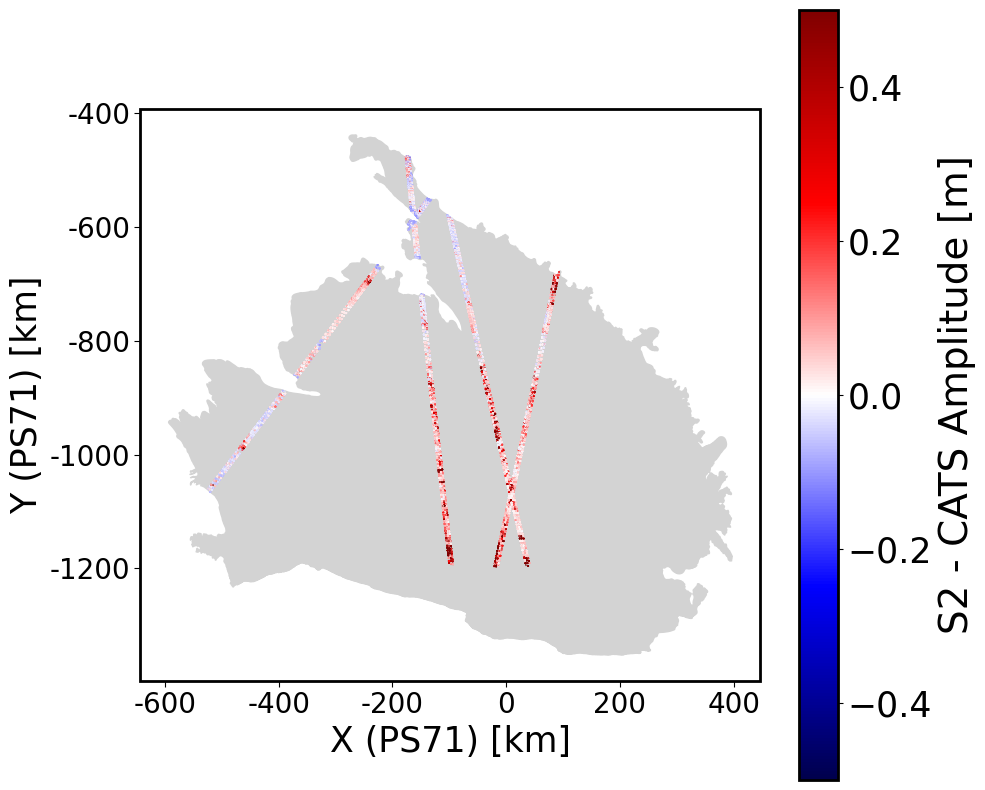

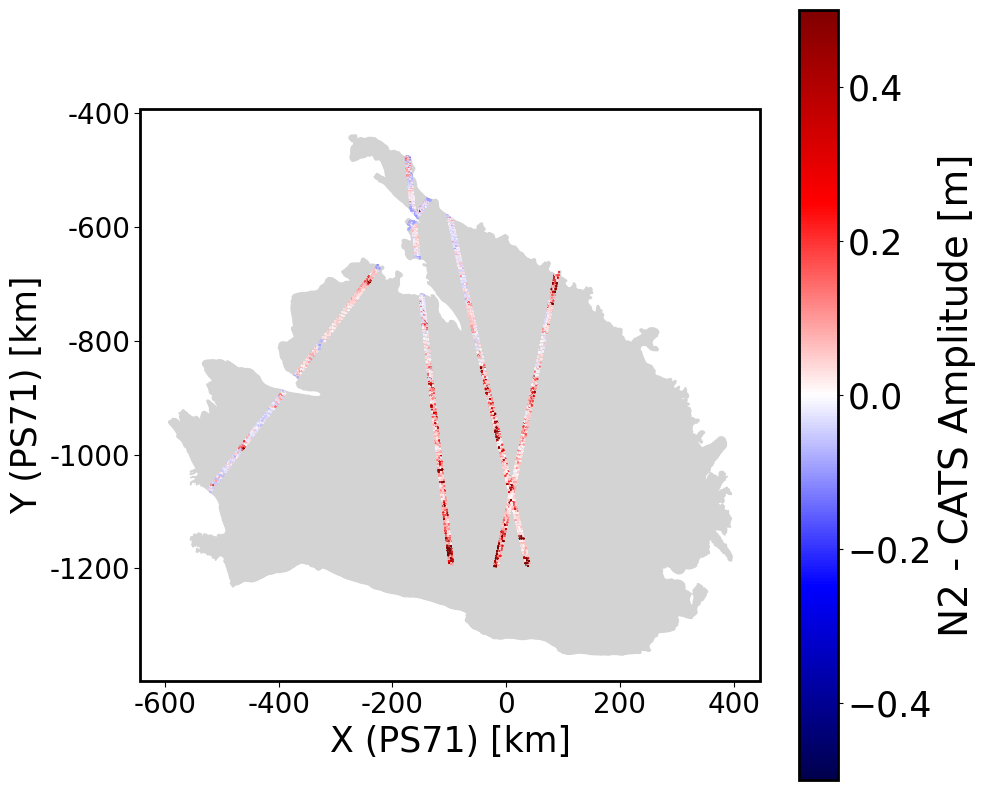

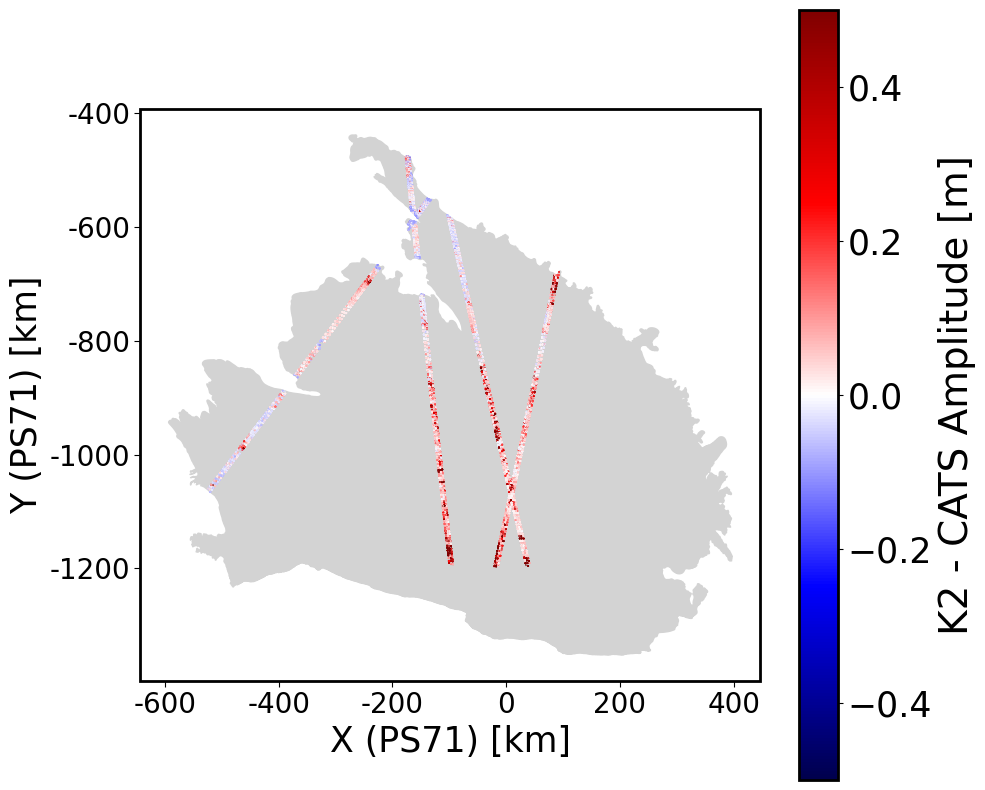

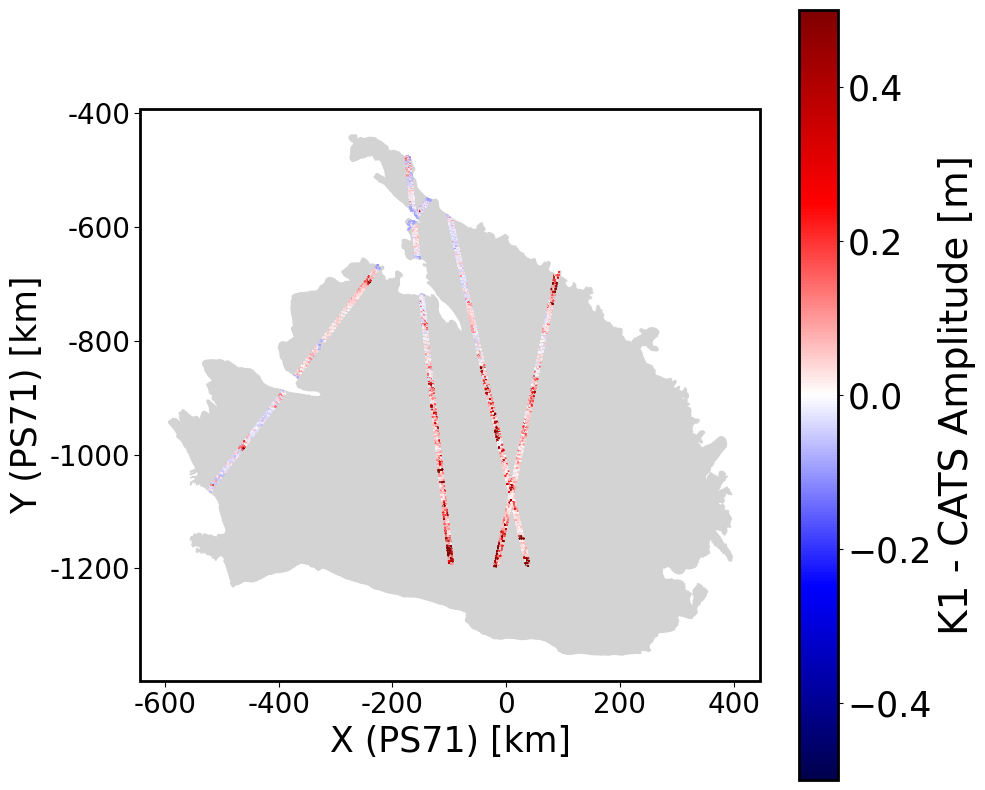

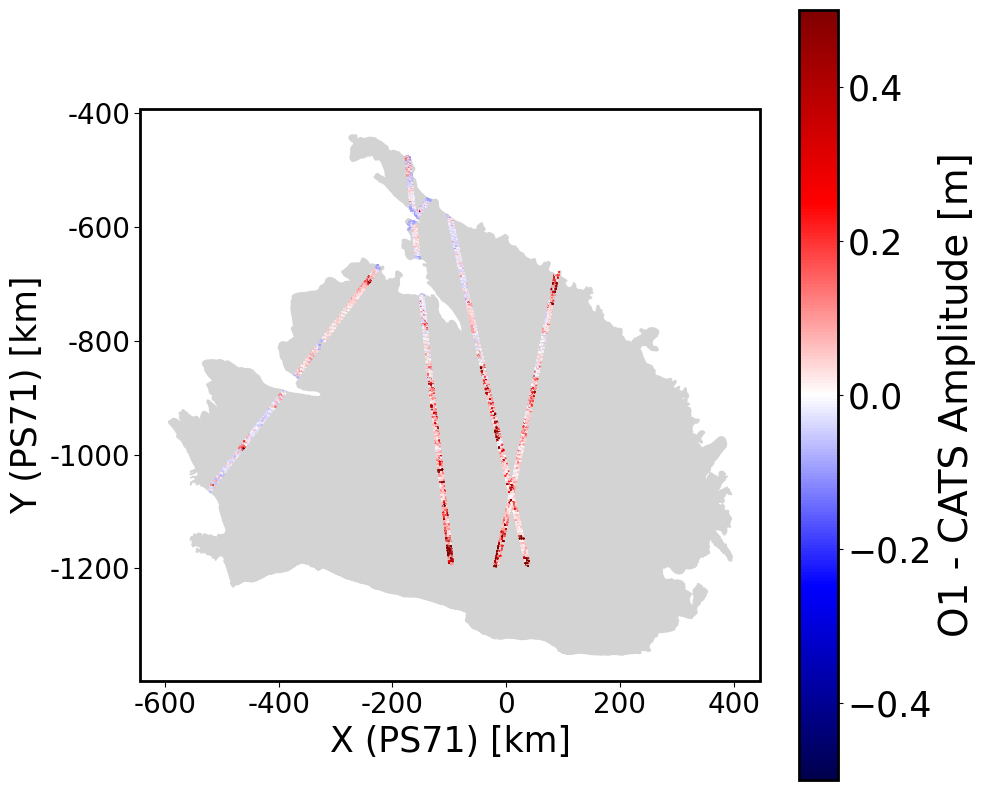

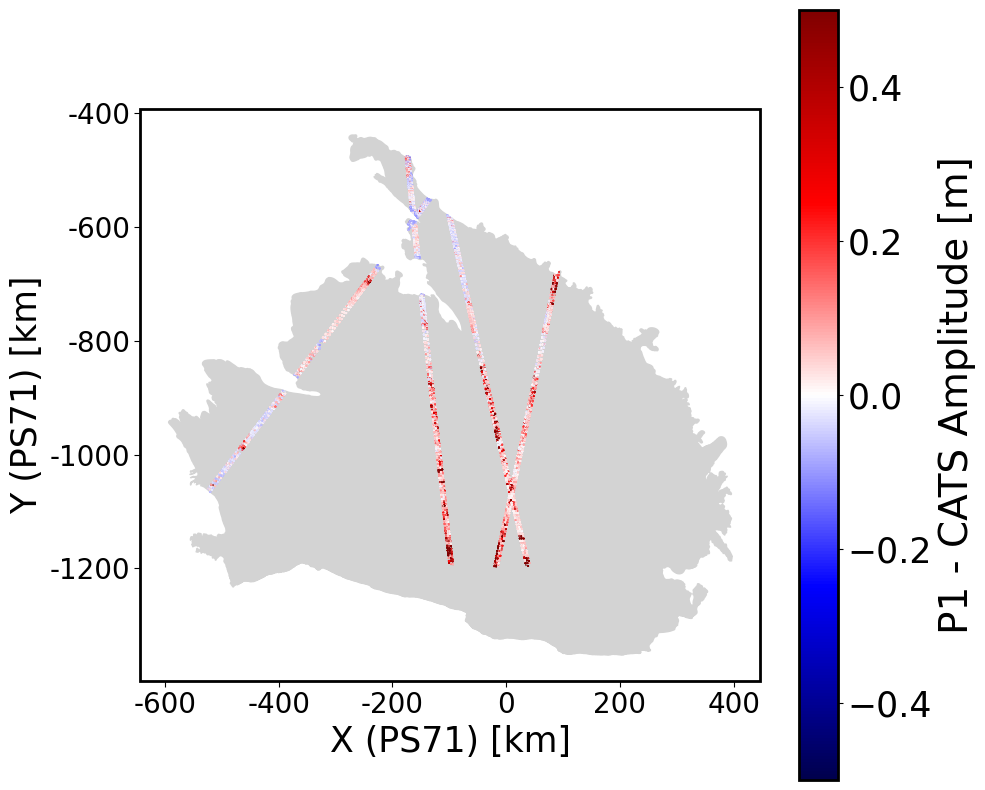

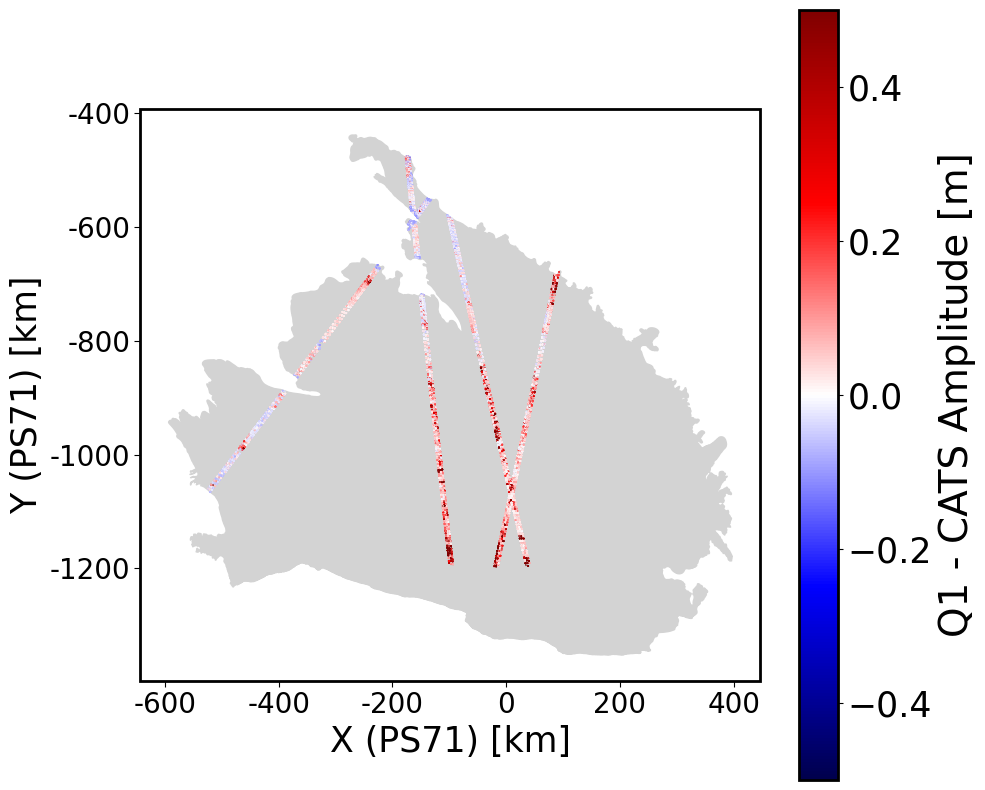

In [36]:
# Plot Difference from CATS
hmin = -0.5
hmax = 0.5
for i, const in enumerate(constituents): # Loop over amplitudes
    ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
    fig, ax = plt.subplots(
        figsize=(10, 10),
        subplot_kw={'projection': ps71_projection},
    )
    plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "lightgray"], ps71_projection, fill=True)

    n = -1
    xs = np.array(tide_analyses['xs'][:n])
    ys = np.array(tide_analyses['ys'][:n])
    amps = np.array([a[0] for a in tide_analyses['amplitudes'][:n]])
    amps_pyTMD = np.array([a[0] for a in tide_analyses['amp_pyTMD'][:n]])
    amp_diff = amps - amps_pyTMD
    col = ax.scatter(xs, ys, s=0.1, zorder=10, c=amp_diff, cmap='seismic',vmin=hmin,vmax=hmax)
    cbar = fig.colorbar(col)

    KM_SCALE = 1e3
    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_xlabel("X (PS71) [km]", size=25)
    ax.set_ylabel("Y (PS71) [km]", size=25)
    ax.tick_params(labelsize=20)
    ax.tick_params(size=4)

    cbar.ax.tick_params(labelsize=25)
    cbar.set_label(f"{const} - CATS Amplitude [m]", fontsize=28, color="black")
    fig.savefig(f"./output/{const}_ha_CATSDiff.png", bbox_inches="tight", dpi=300, transparent=True)

28130


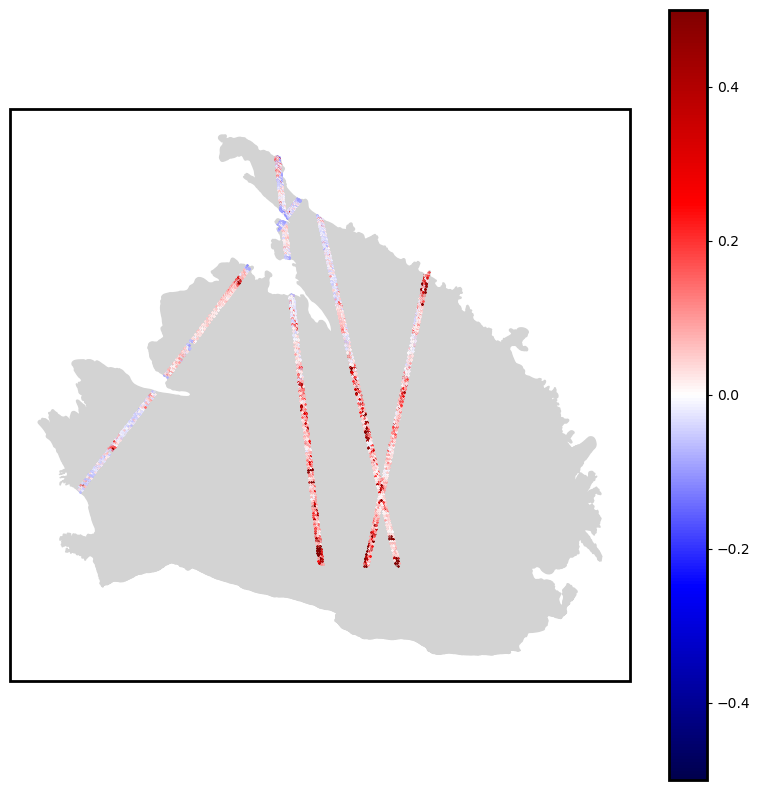

In [14]:
# Plot Difference from CATS
print(len(tide_analyses['xs']))
hmin = -0.5
hmax = 0.5
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ps71_projection},
)
plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "lightgray"], ps71_projection, fill=True)
n = -1
for x,y,amp,phase,amp_pyTMD in zip(tide_analyses['xs'][:n],tide_analyses['ys'][:n],tide_analyses['amplitudes'][:n],tide_analyses['phases'][:n], tide_analyses['amp_pyTMD'][:n]):
    col = ax.scatter(x,y,s=0.1,zorder=10,c=amp[0]-amp_pyTMD[0],cmap='seismic',vmin=hmin,vmax=hmax)

fig.colorbar(col)

In [27]:
# Laurie only wants crossovers with < 90 days
csv_index = 0
filtered_dfs = []
for df in dfs:
    df['time_1'] = pd.to_datetime(df['time_1'])
    df['time_2'] = pd.to_datetime(df['time_2'])

    time_diff = (df['time_1'] - df['time_2']).abs().dt.days

    filtered_df = df[time_diff < 90]
    print(len(filtered_df))
    filtered_dfs.append(filtered_df)

590406
1455621
825092
1022341
808310
1087083
1168180
983521
921375
787386
1288088
800352
1371033
964093
807058
886643
881167
917940
1387894
1262323
892350
1237441
628803
845141
1054144
1126057
1158698
1050126
480297
694967
1415070
1281601
906671
938781
872784
1071761
616694
800966
819564
1580848
706858
1030930
577767
1031732
784717
646140
1190358
957367
632837
1006775
1240977
378761
795174
1101404
981289
1477125
1296738
869533
1149205
507554


In [28]:
combined_df = pd.concat(filtered_dfs, ignore_index=True)
print("Saving Dataframe")
combined_df.to_csv(f"Ross_ATL11Crossovers.csv", index=False)

Saving Dataframe


In [29]:
len(combined_df)

58051911